In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Lambda, Add, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import gc
import json
from pathlib import Path

from pure_pursuit import *
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set()

2024-03-01 12:39:49.873817: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 12:39:49.904827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 12:39:50.342482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-03-01 12:39:51.189454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 12:39:51.194795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 12:39:51.194910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
MODEL_SAVE_DIR = Path("PINN_s")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [4]:
train_config = None
with open("small_train.json", "r") as fp:
    train_config = json.load(fp)

In [5]:
def get_data_files(config, dataset):

    assert dataset in ["empty", "traffic"], "`dataset` should be one of `empty` or `traffic`"

    train_files = [Path(x) for x in config[dataset]["train"]]
    val_files = [Path(x) for x in config[dataset]["val"]]
    test_files = [Path(x) for x in config[dataset]["test"]]
    
    return train_files, val_files, test_files

In [6]:
empty_train_track_files, empty_val_track_files, empty_test_track_files = get_data_files(train_config, "empty")
empty_train_track_files, empty_val_track_files, empty_test_track_files

([PosixPath('../../../torcs_SL/data_all/data/g-track-2/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/aalborg/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/wheel-1/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/g-track-1/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/street-1/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/spring/1.csv'),
  PosixPath('../../../torcs_SL/data_all/data/g-track-2/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/aalborg/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/wheel-1/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/g-track-1/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/street-1/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/spring/2.csv'),
  PosixPath('../../../torcs_SL/data_all/data/g-track-2/3.csv'),
  PosixPath('../../../torcs_SL/data_all/data/aalborg/3.csv'),
  PosixPath('../../../torcs_SL/data_all/data/wheel-1/3.csv'),
  PosixPath('../../../torcs_SL/data_all/data/g-track-1/3.csv

In [7]:
traffic_train_track_files, traffic_val_track_files, traffic_test_track_files = get_data_files(train_config, "traffic")
traffic_train_track_files, traffic_val_track_files, traffic_test_track_files

([PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-2/1.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-2/2.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-2/3.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/aalborg/1.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/aalborg/2.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/aalborg/3.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/wheel-1/1.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/wheel-1/2.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/wheel-1/3.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-1/1.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-1/2.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/g-track-1/3.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/street-1/1.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/street-1/2.csv'),
  PosixPath('../../../torcs_SL/TORCS_DATA/data/street-1/3.csv'),
  PosixPath('../../../tor

### Train-Test Split

In [8]:
empty_training_data = pd.DataFrame()
empty_validation_data = pd.DataFrame()
empty_test_data = pd.DataFrame()

for fi in empty_train_track_files:
    empty_training_data = pd.concat([empty_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in empty_val_track_files:
    empty_validation_data = pd.concat([empty_validation_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in empty_test_track_files:
    empty_test_data = pd.concat([empty_test_data, pd.read_csv(fi)]).reset_index(drop=True)

print (empty_training_data.shape, empty_training_data.shape, empty_test_data.shape)

(146143, 79) (146143, 79) (73072, 79)


In [9]:
traffic_training_data = pd.DataFrame()
traffic_validation_data = pd.DataFrame()
traffic_test_data = pd.DataFrame()

for fi in traffic_train_track_files:
    traffic_training_data = pd.concat([traffic_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in traffic_val_track_files:
    traffic_validation_data = pd.concat([traffic_validation_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in traffic_test_track_files:
    traffic_test_data = pd.concat([traffic_test_data, pd.read_csv(fi)]).reset_index(drop=True)
    
print (traffic_training_data.shape)
print (traffic_validation_data.shape)

(305542, 79)
(116749, 79)


In [10]:
class PurePursuit:
    
    @staticmethod
    def get_max_dist(track):
        track_dists = np.array(track)
        return np.max(track_dists)
    
    @staticmethod
    def get_max_dist_idx(track):
        track_dists = np.array(track)
        if track_dists[9] == np.max(track_dists) or track_dists[9] == 200:
            return 9
        return np.argmax(track_dists)
    
    @staticmethod
    def compute_target_angle(track):

        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)

        max_dist_angle = max_track_dist_idx * 10. - 90.
        return max_dist_angle 
    
    @staticmethod
    def get_lookahead(track):
        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)
        return track[max_track_dist_idx]

    @staticmethod
    def compute_steering(track):

        lookahead = PurePursuit.get_lookahead(track)
        target_angle = PurePursuit.compute_target_angle(track)  # radians

        raw_steering_angle_rad = -math.atan(
            (PURE_PURSUIT_2L * math.sin(target_angle)) / lookahead)

        raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

        normalized_steering_angle = np.clip(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)

        return normalized_steering_angle


    @staticmethod
    def get_empty_space(data, road_cols, traffic_cols):
        return np.max(np.array([data[road_cols].values, data[traffic_cols].values]), axis=0)

In [11]:
def process_data(orig_data):

    data = orig_data.copy()
    
    del data[' Gear']
    del data[' CurrentLapTime']
    del data[' LastLapTime']
    del data[' Damage']
    del data[' FuelLevel']

    del data[' DistanceFromStart']

    # road_cols = [x for x in data.columns if "Track_" in x]
    # traffic_cols = [x for x in data.columns if "Opp" in x][:19]
    # empty_space = np.max(np.array([data[road_cols].values, data[traffic_cols].values]), axis=0)

    data['phy_steer'] = data.loc[:, [' Track_1', 'Track_2', 'Track_3', 'Track_4',
       'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10',
       'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16',
       'Track_17', 'Track_18', 'Track_19']].apply(lambda x : PurePursuit.compute_steering(x.values), axis=1)
    
    # data['phy_steer'] = np.array([PurePursuit.compute_steering(x) for x in empty_space ])
    is_empty = (data.loc[:, [' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36']].values == 200).all().astype(int)

    data['empty'] = is_empty
    
    X = data.loc[:,[' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'empty', 'phy_steer']]

    Y = data.loc[:,'Steering']
    
    return X, Y
    
    

In [12]:
X_train_empty, Y_train_empty = process_data(empty_training_data)
X_val_empty, Y_val_empty = process_data(empty_validation_data)
X_test_empty, Y_test_empty = process_data(empty_test_data)

In [13]:
X_train_traffic, Y_train_traffic = process_data(traffic_training_data)
X_val_traffic, Y_val_traffic = process_data(traffic_validation_data)
X_test_traffic, Y_test_traffic = process_data(traffic_test_data)

## PINN Model Training

In [15]:
X_train_traffic = pd.concat([X_train_traffic, X_train_empty]).reset_index(drop=True)
X_val_traffic = pd.concat([X_val_traffic, X_val_empty]).reset_index(drop=True)
X_test_traffic = pd.concat([X_test_traffic, X_test_empty]).reset_index(drop=True)

Y_train_traffic = np.concatenate([Y_train_traffic, Y_train_empty])
Y_val_traffic = np.concatenate([Y_val_traffic, Y_val_empty])
Y_test_traffic = np.concatenate([Y_test_traffic, Y_test_empty])


scaler = StandardScaler()

scaler.fit(X_train_traffic.iloc[:, :-2])

X_train_traffic.iloc[:, :-2]=scaler.transform(X_train_traffic.iloc[:, :-2])
X_val_traffic.iloc[:, :-2]=scaler.transform(X_val_traffic.iloc[:, :-2])
X_test_traffic.iloc[:, :-2]=scaler.transform(X_test_traffic.iloc[:, :-2])


### Save these means and stds for test time

In [17]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "wb") as fp:
    pickle.dump(scaler, fp)

In [18]:
scaler.mean_

array([ 1.84581759e+02,  1.92284056e+02,  1.94912232e+02,  1.97528787e+02,
        1.98483030e+02,  1.98854762e+02,  1.99059141e+02,  1.99313492e+02,
        1.99311264e+02,  1.99444410e+02,  1.99473436e+02,  1.99475998e+02,
        1.99211856e+02,  1.98729457e+02,  1.98080695e+02,  1.95908551e+02,
        1.94132752e+02,  1.85849934e+02,  1.83909302e+02,  1.92105716e+02,
        1.96374528e+02,  1.97986217e+02,  1.98612770e+02,  1.98772125e+02,
        1.98721550e+02,  1.98847365e+02,  1.98802291e+02,  1.98781918e+02,
        1.98768750e+02,  1.98472433e+02,  1.98045799e+02,  1.97397929e+02,
        1.96694664e+02,  1.94875090e+02,  1.90896219e+02,  1.81186931e+02,
        6.12618240e+00,  6.27799816e+00,  7.91170429e+00,  1.05984171e+01,
        2.00912367e+01,  2.68322117e+01,  3.83411185e+01,  6.40985191e+01,
        8.29004509e+01,  8.36424499e+01,  8.36098759e+01,  6.90335823e+01,
        4.63584070e+01,  2.70122466e+01,  2.10524368e+01,  1.30041477e+01,
        9.72683336e+00,  

In [19]:
scaler.scale_

array([4.59694368e+01, 3.33697333e+01, 2.66938150e+01, 1.78242432e+01,
       1.33790475e+01, 1.12617694e+01, 1.02636276e+01, 8.73684765e+00,
       9.11345489e+00, 7.88627722e+00, 7.67197516e+00, 7.80015771e+00,
       9.65565505e+00, 1.21252046e+01, 1.55390094e+01, 2.30687058e+01,
       2.85840453e+01, 4.34978264e+01, 4.56038844e+01, 3.30667929e+01,
       2.28692881e+01, 1.65357604e+01, 1.33555936e+01, 1.20578066e+01,
       1.23552308e+01, 1.19522052e+01, 1.26988559e+01, 1.26636703e+01,
       1.25119124e+01, 1.37751447e+01, 1.57037861e+01, 1.86532128e+01,
       2.15115302e+01, 2.72910880e+01, 3.62051288e+01, 5.02967524e+01,
       4.10320037e+00, 3.77604899e+00, 4.94226452e+00, 6.86239361e+00,
       1.94714025e+01, 2.20144612e+01, 2.47487968e+01, 4.00155404e+01,
       5.78675509e+01, 5.72481711e+01, 5.66182337e+01, 4.29162408e+01,
       3.24754389e+01, 1.48103053e+01, 1.20434762e+01, 7.90971380e+00,
       5.31480126e+00, 4.66006010e+00, 4.46259868e+00, 5.00790101e-01,
      

In [20]:
np.save(MODEL_SAVE_DIR.joinpath("means.npy"), scaler.mean_)
np.save(MODEL_SAVE_DIR.joinpath("stds.npy"), scaler.scale_)

### Training with physics as regularizer in loss

In [73]:
@tf.function
def pinn_loss(y_true, y_pred):
    
    y_data = tf.reshape(y_true[:, 0], tf.shape(y_pred))
    y_phy = tf.reshape(y_true[:, 1], tf.shape(y_pred))
    empty = tf.reshape(y_true[:, 2], tf.shape(y_pred))

    return tf.reduce_mean(tf.abs(y_data - y_pred)) + tf.reduce_mean(empty*tf.abs(y_phy - y_pred))
  

In [74]:
loss = pinn_loss  # 'mean_absolute_error'
learning_rate=1e-3

model=Sequential()
model.add(Dense(64, input_shape=(X_train_traffic.shape[1]-2,) ,activation='relu',kernel_initializer='he_normal'))
# model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
# model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
# model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
# model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(32,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(16,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(8,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(1, kernel_initializer='he_normal'))
model.compile(optimizer=Adam(learning_rate),loss=loss,metrics=['mae'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                4224      
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dense_63 (Dense)            (None, 8)                 136       
                                                                 
 dense_64 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,977
Trainable params: 6,977
Non-trainable params: 0
_________________________________________________________________


In [75]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)
stats = model.fit(X_train_traffic.iloc[:,:-2],np.vstack([Y_train_traffic, X_train_traffic.iloc[:,-1], X_train_traffic.iloc[:,-2]]).T,
                  validation_data=(X_val_traffic.iloc[:,:-2],np.vstack([Y_val_traffic, X_val_traffic.iloc[:,-1], X_val_traffic.iloc[:,-2]]).T),batch_size=512,epochs=epochs,callbacks=[reduce_lr])

Epoch 1/50
883/883 [==============================] - 3s 2ms/step - loss: 0.0986 - mae: 0.1863 - val_loss: 0.0964 - val_mae: 0.2049 - lr: 0.0010
Epoch 2/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0768 - mae: 0.1854 - val_loss: 0.0911 - val_mae: 0.2054 - lr: 0.0010
Epoch 3/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0714 - mae: 0.1854 - val_loss: 0.0895 - val_mae: 0.2049 - lr: 0.0010
Epoch 4/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0684 - mae: 0.1854 - val_loss: 0.0883 - val_mae: 0.2064 - lr: 0.0010
Epoch 5/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0666 - mae: 0.1853 - val_loss: 0.0876 - val_mae: 0.2059 - lr: 0.0010
Epoch 6/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0656 - mae: 0.1852 - val_loss: 0.0863 - val_mae: 0.2059 - lr: 0.0010
Epoch 7/50
883/883 [==============================] - 2s 2ms/step - loss: 0.0646 - mae: 0.1851 - val_loss: 0.0866 - val_mae: 0.206

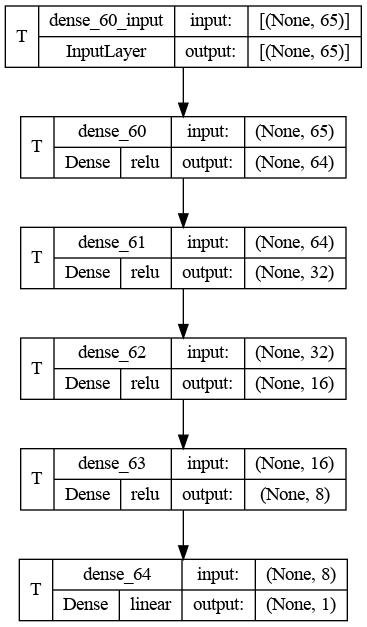

In [77]:
plot_model(model,MODEL_SAVE_DIR.joinpath("model.png"), show_shapes=True, expand_nested=True, show_layer_activations=True, show_trainable=True)

In [94]:
preds = model.predict(np.concatenate([X_test_traffic.iloc[:,:-2], X_val_traffic.iloc[:,:-2]]))
y = np.concatenate([Y_test_traffic, Y_val_traffic])
y_phy = np.concatenate([X_test_traffic.iloc[:,-1], X_val_traffic.iloc[:,-1]]) 
empty = np.concatenate([X_test_traffic.iloc[:,-2], X_val_traffic.iloc[:,-2]]) 

12743/12743 [==============================] - 7s 514us/step


In [92]:
np.vstack((y, y_phy)).T.shape

(407758, 2)

In [95]:
model.evaluate(np.concatenate([X_test_traffic.iloc[:,:-2], X_val_traffic.iloc[:,:-2]]), np.vstack((y, y_phy, empty)).T)

12743/12743 [==============================] - 10s 777us/step - loss: 0.0770 - mae: 0.1939


[0.07704474776983261, 0.19391430914402008]

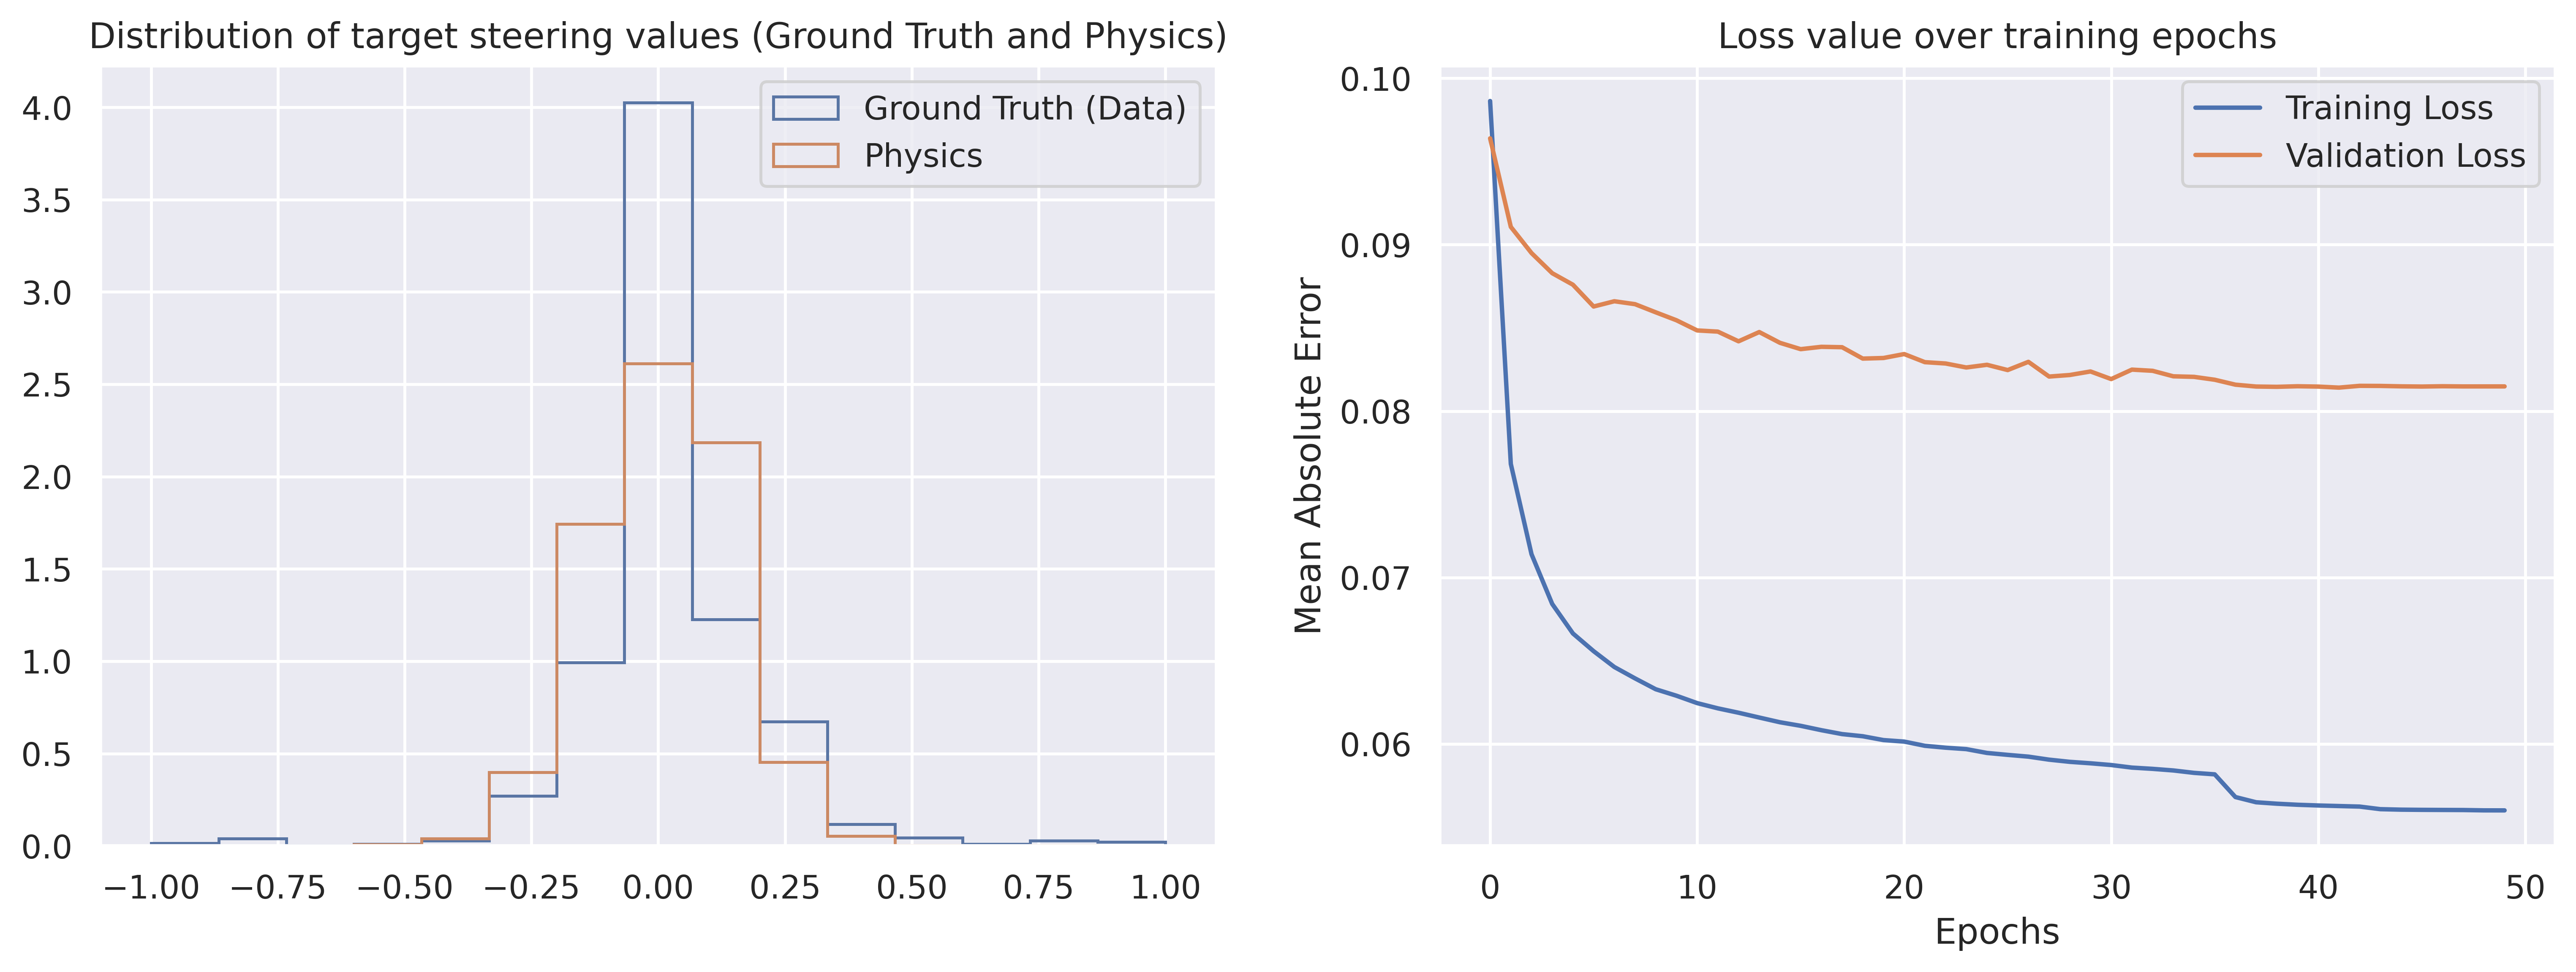

In [96]:
fig, ax = plt.subplots(ncols=2, dpi=500)
fig.set_figwidth(15)

ax[0].hist(y, bins=15, density=True, color='#5975A4', histtype='step')
ax[0].hist(y_phy, bins=15, density=True, color='#CC8963', histtype='step')
handles = [Rectangle((0, 0), 1, 1, fill=False, ec='#5975A4'), Rectangle((0, 0), 1, 1, ec='#CC8963', fill=False)]
labels = ["Ground Truth (Data)", "Physics"]
ax[0].legend(handles, labels)

ax[0].set_title("Distribution of target steering values (Ground Truth and Physics)")


ax[1].plot(stats.history['loss'])
ax[1].plot(stats.history['val_loss'])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Mean Absolute Error")
ax[1].set_title("Loss value over training epochs")

fig.savefig(MODEL_SAVE_DIR.joinpath("pinn_issues.png"))

In [97]:
model.save(MODEL_SAVE_DIR.joinpath('model.h5'))